**todo**:
- add info about meaning of dop and hintset
- add schema
- add comments about raw data structure (hs_to ..., planning_time, etc.)
- explain regressions
- rethink the scale and query naming
- keep in mind the problem with planning time in explain analyze timout cases`

In [2]:
import sys

sys.path.insert(0, "/Users/zinchse/GitHub/hero")
from json import load, dumps, dump
import os

In [3]:
from src.datasets.oracle import Oracle, OracleRequest

In [54]:
from functools import lru_cache


@lru_cache
def get_data(bench_name, dop):
    oracle = Oracle(f"/Users/zinchse/GitHub/hero/data/processed/{bench_name}")
    data = {}
    query_names = oracle.get_query_names()
    for query_name in query_names:
        min_time = float("inf")
        max_time = float("-inf")
        best_hs = worst_hs = 0
        best_boost, worst_boost = -float("inf"), float("inf")

        def_request = OracleRequest(query_name=query_name, dop=dop, hintset=0)
        def_time = oracle.get_execution_time(request=def_request)

        for hs in range(128):
            request = OracleRequest(query_name=query_name, dop=dop, hintset=hs)
            time = oracle.get_execution_time(request=request)

            if min_time > time:
                min_time = time
                best_hs = hs
                best_boost = def_time / min_time
            if max_time < time:
                max_time = time
                worst_hs = hs
                worst_boost = min(2, max_time / def_time)

        data[query_name] = {"worst": (max_time, worst_hs, worst_boost), "best": (min_time, best_hs, best_boost), "default_time": def_time}
    return data

In [23]:
GREEN = "#3f993c"
ORANGE = "#fcaa2f"
BLUE = "cyan"
RED = "#a00d30"

In [32]:
def extract_query_number(query_name):
    import re
    return int(re.search(r'-?\d+\.?\d*', query_name).group())

In [39]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for bench_name in ["JOB", "tpch_10gb", "sample_queries"]:
    for dop in [1, 16, 64]:
        data = get_data(bench_name=bench_name, dop=dop)
        total_def_time, total_best_time = 0, 0
        for query_data in data.items()
            total_def_time += query_data["default_time"]
            total_best_time += query_data["best"][0]
        boost = total_def_time / total_best_time

        plt.style.use('seaborn-v0_8-paper')
        fig, ax = plt.subplots(figsize=(30, 8))
        
        index = np.arange(len(names))
        bar_width = 0.7


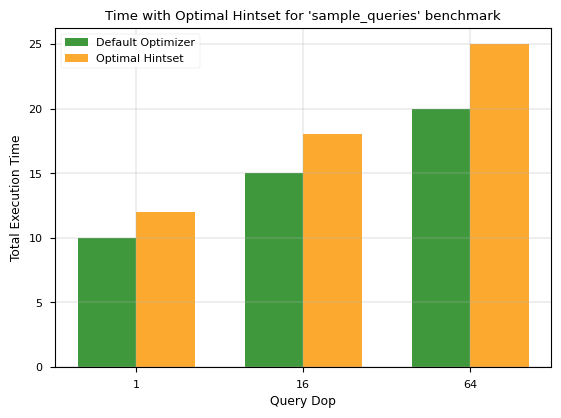

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
query_dops = [1, 16, 64]
baseline_values = [10, 15, 20]  # Example values for baseline
record_values = [12, 18, 25]    # Example values for record

# Position of bars on the x-axis
ind = np.arange(len(query_dops))

# Width of a bar 
width = 0.35 

plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots()

rects1 = ax.bar(ind - width/2, baseline_values, width, label='Default Optimizer', color=GREEN)
rects2 = ax.bar(ind + width/2, record_values, width, label='Optimal Hintset', color=ORANGE)

ax.set_xlabel('Query Dop')
ax.set_ylabel('Total Execution Time')
ax.set_title(f"Time with Optimal Hintset for '{bench_name}' benchmark")
ax.set_xticks(ind)
ax.set_xticklabels(query_dops)
ax.legend()
ax.grid(True, which='both', linestyle='-', linewidth=0.3)
plt.show()


AttributeError: Line2D.set() got an unexpected keyword argument 'x'

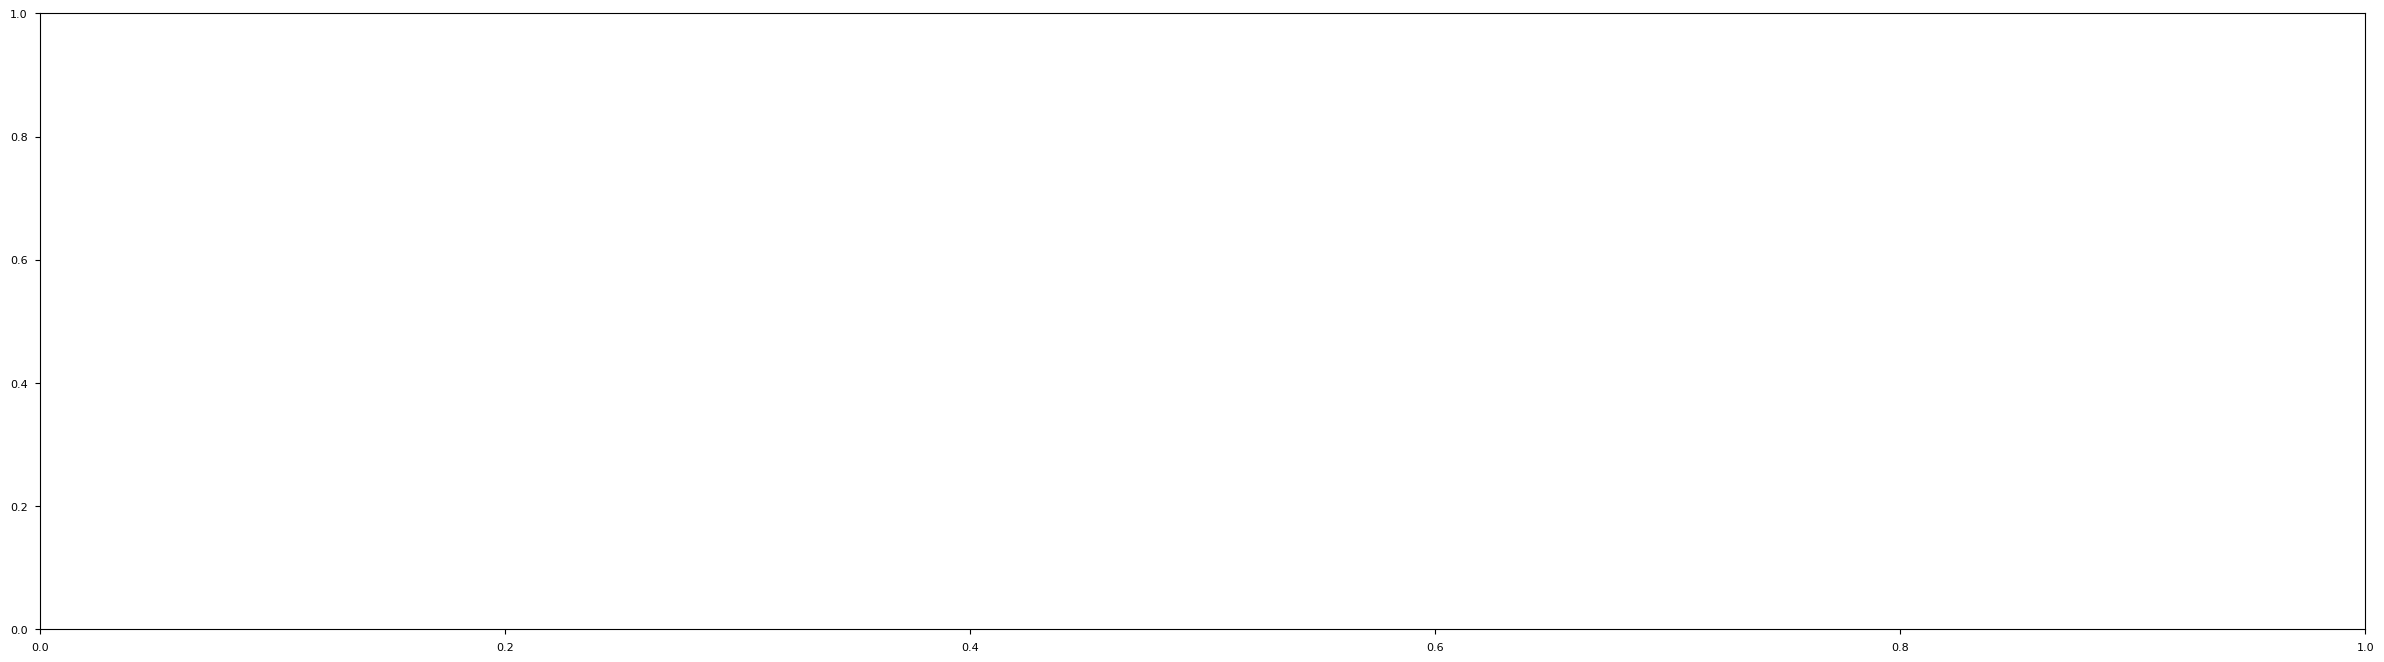

In [74]:
import numpy as np
import matplotlib.pyplot as plt

TIMEOUT_REL = 2
TIMEOUT_HEIGHT = 1

for bench_name in ["JOB", "tpch_10gb", "sample_queries"]:
    for dop in [1, 16, 64]:
        data = get_data(bench_name=bench_name, dop=dop)

        names, max_boosts, max_degradations = [], [], []
        for query_name in sorted(data.keys(), key=extract_query_number):
            query_data = data[query_name]
            names.append(query_name)
            max_boosts.append(query_data["best"][2])
            max_degradations.append(query_data["worst"][2])

        plt.style.use('seaborn-v0_8-paper')
        fig, ax = plt.subplots(figsize=(30, 8))
        
        index = np.arange(len(names))
        bar_width = 0.7

        ax.axhline(y=1.0, xmin=index[0]-bar_width, xmax=index[-1]+bar_width, color='black', linewidth=1, linestyle='-', label='Default Time')
        boost_bars = ax.bar(index, max_boosts, bar_width, label="Max Boost", color=GREEN)
        banned_index = [index[i] for i, degradation in enumerate(max_degradations) if degradation == TIMEOUT_REL]
        banned_bars = ax.bar(
            banned_index, [-TIMEOUT_HEIGHT for x in banned_index], bar_width, label="Max Degradation (Timeout)", color=RED
        )
        
        ax.set_yscale("symlog")
        ax.grid(True, which='both', linestyle='-', linewidth=0.3)
        ax.set_xlabel("Query")
        ax.set_ylabel("Relative Performance (log scale)")
        ax.set_title(f"Boost and Degradation on benchmark '{bench_name}' with query_dop {dop}")
        ax.set_xticks(index)
        ax.set_xticklabels(names, rotation=90)
        ax.legend()
        plt.show()

# Structure

- define pydantic dataset model and dump its structure (including tree after processing)

> Once you've reviewed the data and validated that it meets your needs, merge the data branch to your collaboration branch and close the issue. You should also be sure to include documentation for all datasets used in the project.
> 
> **Tests and Schemas** It's a good idea to write data **validation tests** and capture **schema definitions** as part of this step. This will reduce issues later on and create more clarity for the team.

- why distance is %? std = % of mean why